# Домашнее задание "Элементарные методы анализа временных рядов"

## Задание

Взять из прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [201]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
from scipy.stats import boxcox

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [202]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    plt.figure(figsize=figsize)  
    plt.plot(y)
    plt.show()
    
    return

### 1. Стационарный ряд.

Единственный стационарный ряд из прошлого задания был показан в лекции, поэтому для домашнего задания будем использовать ряд weekly-closings-of-the-dowjones, предварительно приведя его к стационарному

In [203]:
closing_df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

closing = pd.Series(closing_df.Close)

closing_df.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [204]:
# Дифференцируем
closing_diff = np.diff(closing, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


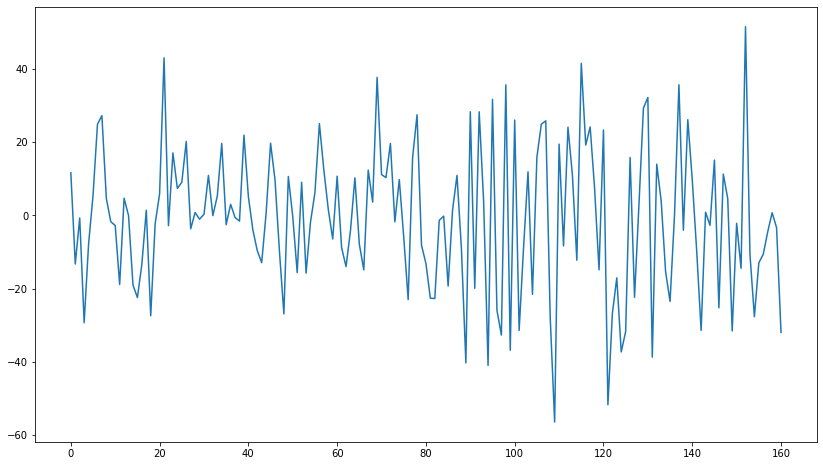

In [205]:
tsplot(closing_diff)

Для приближения этого ряда будем использовать 2 модели: 
- MA. Эта модель выбрана, так как ряд очень шумный, сезонности по графику не видно, возможно, модель поможет увидеть тренд. 
- EMA. Эту модель возьмём для сравнения.

Для измерения качества буду использовать RMSE.

In [206]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    return series.rolling(n).mean()

def predict_moving_average(series, N, n_pred):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

def mse(predictions, test):
    error = mean_squared_error(predictions, test, squared=False)
    print(error)

Чтобы посмотреть, есть ли какой-то тренд, возьмём большой размер окна

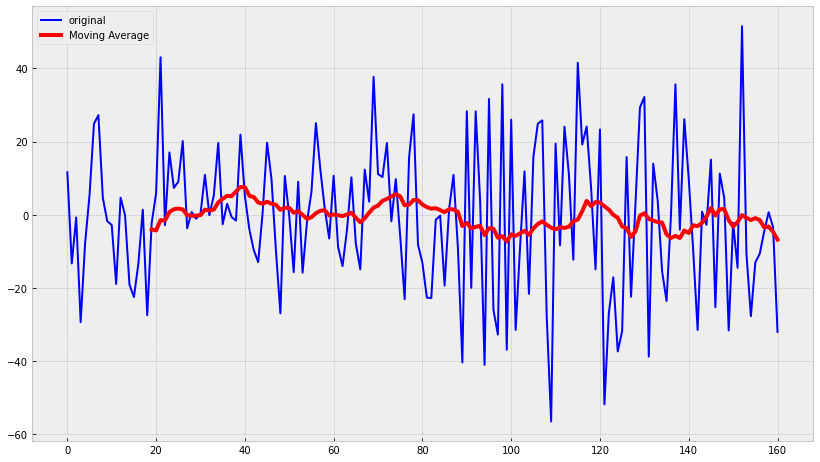

In [207]:
closing_ma = moving_average(closing_diff, 20)

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(closing_diff, color='blue',label='original')
    plt.plot(closing_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

Судя по графику, здесь нет тренда.

Теперь попробуем посчитать RMSE. Я не буду делать предсказания (не вижу особого смысла на этой модели), а просто посчитаю метрику на всей выборке (не считая хвоста)

In [208]:
mse(closing_ma.dropna(), pd.Series(closing_diff).iloc[19:])

19.966452069482894


In [209]:
def exponential_moving_average(series, alpha):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [210]:
ema = exponential_moving_average(closing_diff, 0.2)

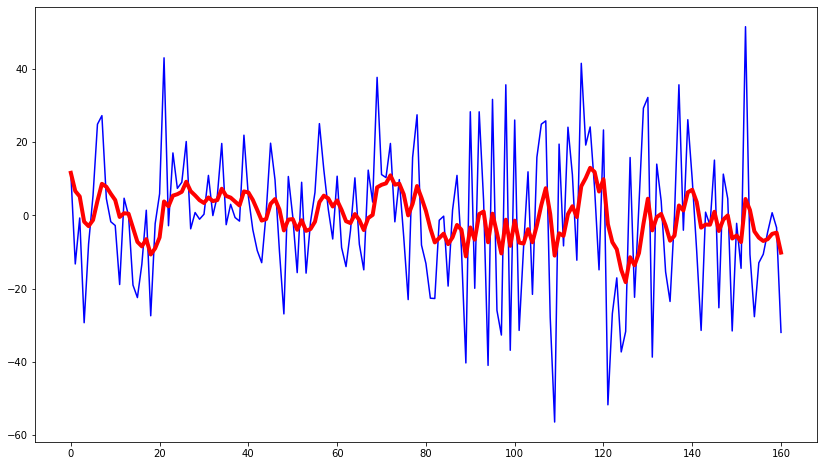

In [213]:
plt.figure(figsize=(14, 8))
plt.plot(closing_diff, color='blue',label='original')
plt.plot(ema, color='red', linewidth='4', label='EMA')

In [212]:
mse(ema, pd.Series(closing_diff))

16.8967090581958


Качество получилось получше, но мне кажется тут не очень корректно сравнивать, так как результат зависит от размера окна для MA и от гиперпараметра альфа для EMA

### 2. Нестационарный ряд.

Будем использовать ряд monthly-car-sales-in-quebec-1960

In [214]:
car_sales_df = pd.read_csv("Series/monthly-car-sales-in-quebec-1960.csv")

car_sales = car_sales_df.Count

car_sales_df.head()

,Month,Count
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


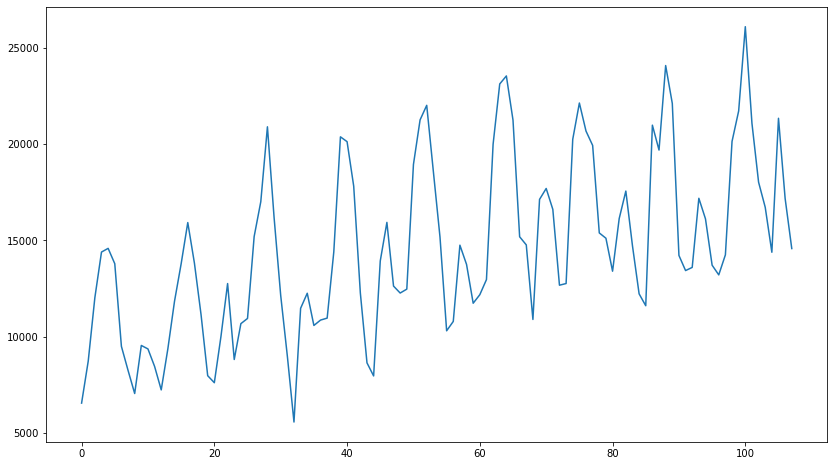

In [215]:
tsplot(car_sales)

Для приближения этого ряда будем использовать модель TEMA (Хольта-Винтерса), так как по графику видно, что есть и тренд, и сезонность

In [216]:
def initial_trend(series, season_len):
    i = 0
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=0):
    if not isinstance(ser, pd.Series):
        ser = pd.Series(ser)
        
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

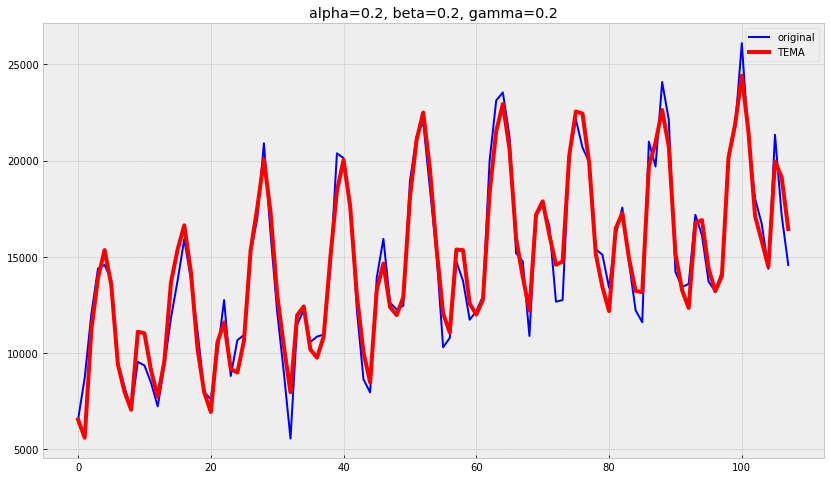

In [217]:
plot_tema(0.2, 0.2, 0.2, car_sales, car_sales)

Попробуем подобрать гиперпараметры

In [218]:
from scipy.optimize import minimize

In [219]:
train, test = car_sales[:80], car_sales[80:]

In [220]:
from scipy.optimize import minimize

def rmse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test, squared=False)
    return error

In [221]:
opt = minimize(rmse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [222]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 1597.3167997627695
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.17128059,  -0.25281679, 121.07404928])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 236
      nit: 30
     njev: 59
   status: 0
  success: True
        x: array([0.02770575, 0.01433606, 0.        ])


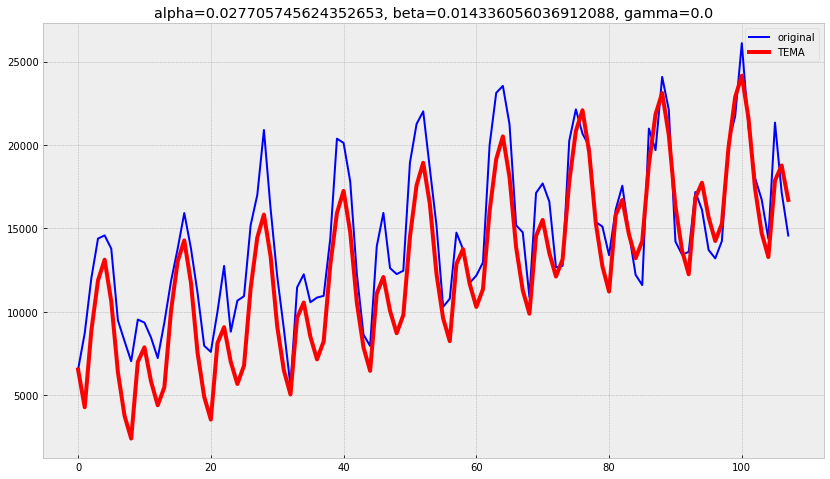

In [223]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=car_sales, n_preds=len(test))

Судя по подобранным параметрам, коэф. гамма равен нулю, хотя видно, что сезонность есть. Мне кажется, лучше оставить первый вариант.